#  Домашнее задание 10 к курсу Pytorch

Задание по итогам курса:
(упрощенное/для тех, у кого нет вебкамеры)

Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
(более сложное)

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры.
В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab
У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

Данная промежуточная аттестация оценивается по системе "зачет" / "не зачет"
Зачет" ставится, если слушатель успешно выполнил задание 1 или 2 задания
"Незачет"" ставится, если слушатель не выплнил 0 заданий

Критерии оценивания:
Слушатель написал приложение, которое будет получать на вход изображение
Слушатель написать приложение, которое будет считывать и выводить кадры с веб-камеры

In [1]:
# захват фото с камеры
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


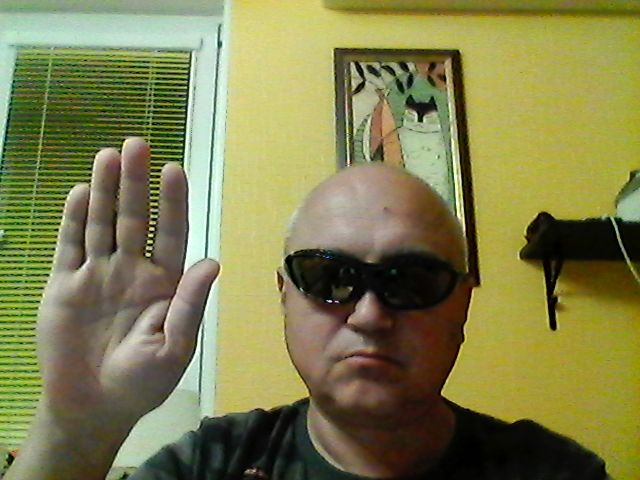

In [3]:
 # сохранение фото
 from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [ ]:
DATASET_FILEPATH = Path('/kaggle/input/leapgestrecog/leapGestRecog/')
IMG_SIZE = 256
RANDOM_STATE = 42

Подготовка датасета

In [ ]:
import re

def gest_label_encoding(gest):
    code = re.findall('^\d*', gest)[0]
    return int(code)-1

def make_df_from_files(parent_dir_path=DATASET_FILEPATH):
    result = list()
    for person in os.listdir(parent_dir_path):
        person_path = parent_dir_path.joinpath(person)
        for gest in os.listdir(person_path):
            gest_path = person_path.joinpath(gest)
            for img in os.listdir(gest_path):
                result.append([img, gest_path.joinpath(img), gest_label_encoding(gest), person])

    return result

In [ ]:
gest_df = pd.DataFrame(make_df_from_files(), columns=('img', 'path', 'gest', 'person'))
gest_df.sample(5)

In [ ]:
gest_df['gest'].unique()

In [ ]:
class LeapGests(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing

        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 2]
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)

        if self.preprocessing is not None:
            img = self.preprocessing(img)

        gest = self.image_gest[idx]

        return img, gest

In [ ]:
train_tfms = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor()])

valid_tfms = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

In [ ]:
batch_size = 64

train_dataset = LeapGests(gest_df, train_tfms)
valid_dataset = LeapGests(gest_df, valid_tfms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=1)

In [ ]:
for img, lbl in train_loader:
    print(img.shape)
    print(lbl[0])
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
from torchvision import models

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
for param in list(resnet50.parameters())[:]:
  param.requires_grad = False

In [ ]:
resnet50.fc = nn.Linear(2048, 10)

In [ ]:
summary(resnet50.to(device), input_size=(3, 32, 32))

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
epoch_losses = []

for epoch in range(epochs):

    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss.append(loss.item())

    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(valid_loader):
        resnet50.eval()
        data = data.to(device)
        labels = labels.to(device)

        outputs = resnet50(data)
        loss = F.cross_entropy(outputs, labels)

        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())


    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss), 'test loss:', np.mean(test_epoch_loss))
    epoch_losses.append(epoch_loss)

In [ ]:
torch.save(resnet50, './gest_detection_model.pth')

In [ ]:
with torch.no_grad():
    for i, data in enumerate(valid_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = resnet50(images)
        plt.title(f'pred - {outputs[0].argmax()}, gt - {labels[0]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>15:
            break